# <h1 align="center">COSC2753 - Machine Learning</h1>

<h2 align="center">Group Machine Learning Project</h2>

# TABLE OF CONTENT



# I. IMPORT NECESSARY LIBRARIES

In [3]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import importlib
import random
import os

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Import custom libraries
import utils.visualizations as vi
import utils.preprocessing as pr
import utils.model_training as tr
importlib.reload(vi)
importlib.reload(pr)
importlib.reload(tr)

<module 'utils.model_training' from 'd:\\.platformio\\penv\\COSC2753-machine-learning-assignment-2\\utils\\model_training.py'>

## Import Tensorflow for TensorFlow ≤ 2.12

In [ ]:
# Deep learning libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.regularizers import l2
from tensorflow.keras import regularizers
# Transfer learning models
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras import models

## Using Keras for Keras 3.x with TensorFlow ≥ 2.13

In [101]:
# # Deep learning libraries
# import tensorflow as tf
# from keras import Sequential, layers, models, Input
# from keras.regularizers import l2
# from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
# from keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.src.legacy.preprocessing.image import ImageDataGenerator
# from keras.initializers import GlorotUniform

# # Transfer learning models
# from keras.applications import EfficientNetB0, ResNet50
# from keras import models

# II. LOADING DATASET

In [102]:
df = pd.read_csv('./inputs/training_df.csv')
df

image_id                  label variety  age  \
0      100330.jpg  bacterial_leaf_blight   ADT45   45   
1      100365.jpg  bacterial_leaf_blight   ADT45   45   
2      100382.jpg  bacterial_leaf_blight   ADT45   45   
3      100632.jpg  bacterial_leaf_blight   ADT45   45   
4      101918.jpg  bacterial_leaf_blight   ADT45   45   
...           ...                    ...     ...  ...   
10402  107607.jpg                 tungro   Zonal   55   
10403  107811.jpg                 tungro   Zonal   55   
10404  108547.jpg                 tungro   Zonal   55   
10405  110245.jpg                 tungro   Zonal   55   
10406  110381.jpg                 tungro   Zonal   55   

                                              image_path  
0      ./inputs/train_images/bacterial_leaf_blight/10...  
1      ./inputs/train_images/bacterial_leaf_blight/10...  
2      ./inputs/train_images/bacterial_leaf_blight/10...  
3      ./inputs/train_images/bacterial_leaf_blight/10...  
4      ./inputs/train_images/bacterial_leaf_blight/10...  
...                                                  ...  
10402            ./inputs/train_images/tungro/107607.jpg  
10403            ./inputs/train_images/tungro/107811.jpg  
10404            ./inputs/train_images/tungro/108547.jpg  
10405            ./inputs/train_images/tungro/110245.jpg  
10406            ./inputs/train_images/tungro/110381.jpg  

[10407 rows x 5 columns]

# IV. MODEL TRAINING

To ensure that the results are stable for multiple run time, we setup the seed for dataset

In [103]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 3) Task 2: Variety Classification

### 3.1) Helper Functions

### 3.2 Data Preprocessing 

#### 3.1) Split the dataset

Before applying any preprocessing technique, we must split the dataset into training and validation sets to avoid data leakage.

In [104]:
# Define random_state
random_state = 42

train_df, val_df = train_test_split(df, test_size=0.2, random_state=random_state)

vi.print_header("Train Dataset shape")
print("Number of Rows: ", train_df.shape[0])
print("Number of Columns: ", train_df.shape[1])

vi.print_header("Validation Dataset Shape")
print("Number of Rows: ", val_df.shape[0])
print("Number of Columns: ", val_df.shape[1])

+-----------------------------------------+
|           TRAIN DATASET SHAPE           |
+-----------------------------------------+
Number of Rows:  8325
Number of Columns:  5
+----------------------------------------------+
|           VALIDATION DATASET SHAPE           |
+----------------------------------------------+
Number of Rows:  2082
Number of Columns:  5


#### 3.2) Handle Imbalance Dataset

In the training dataset, the `variety` distribution is **extremely imbalanced**, with the `ADT45` accounting for over **65%** of the samples. This problem will cause significant bias if it is not handled properly.

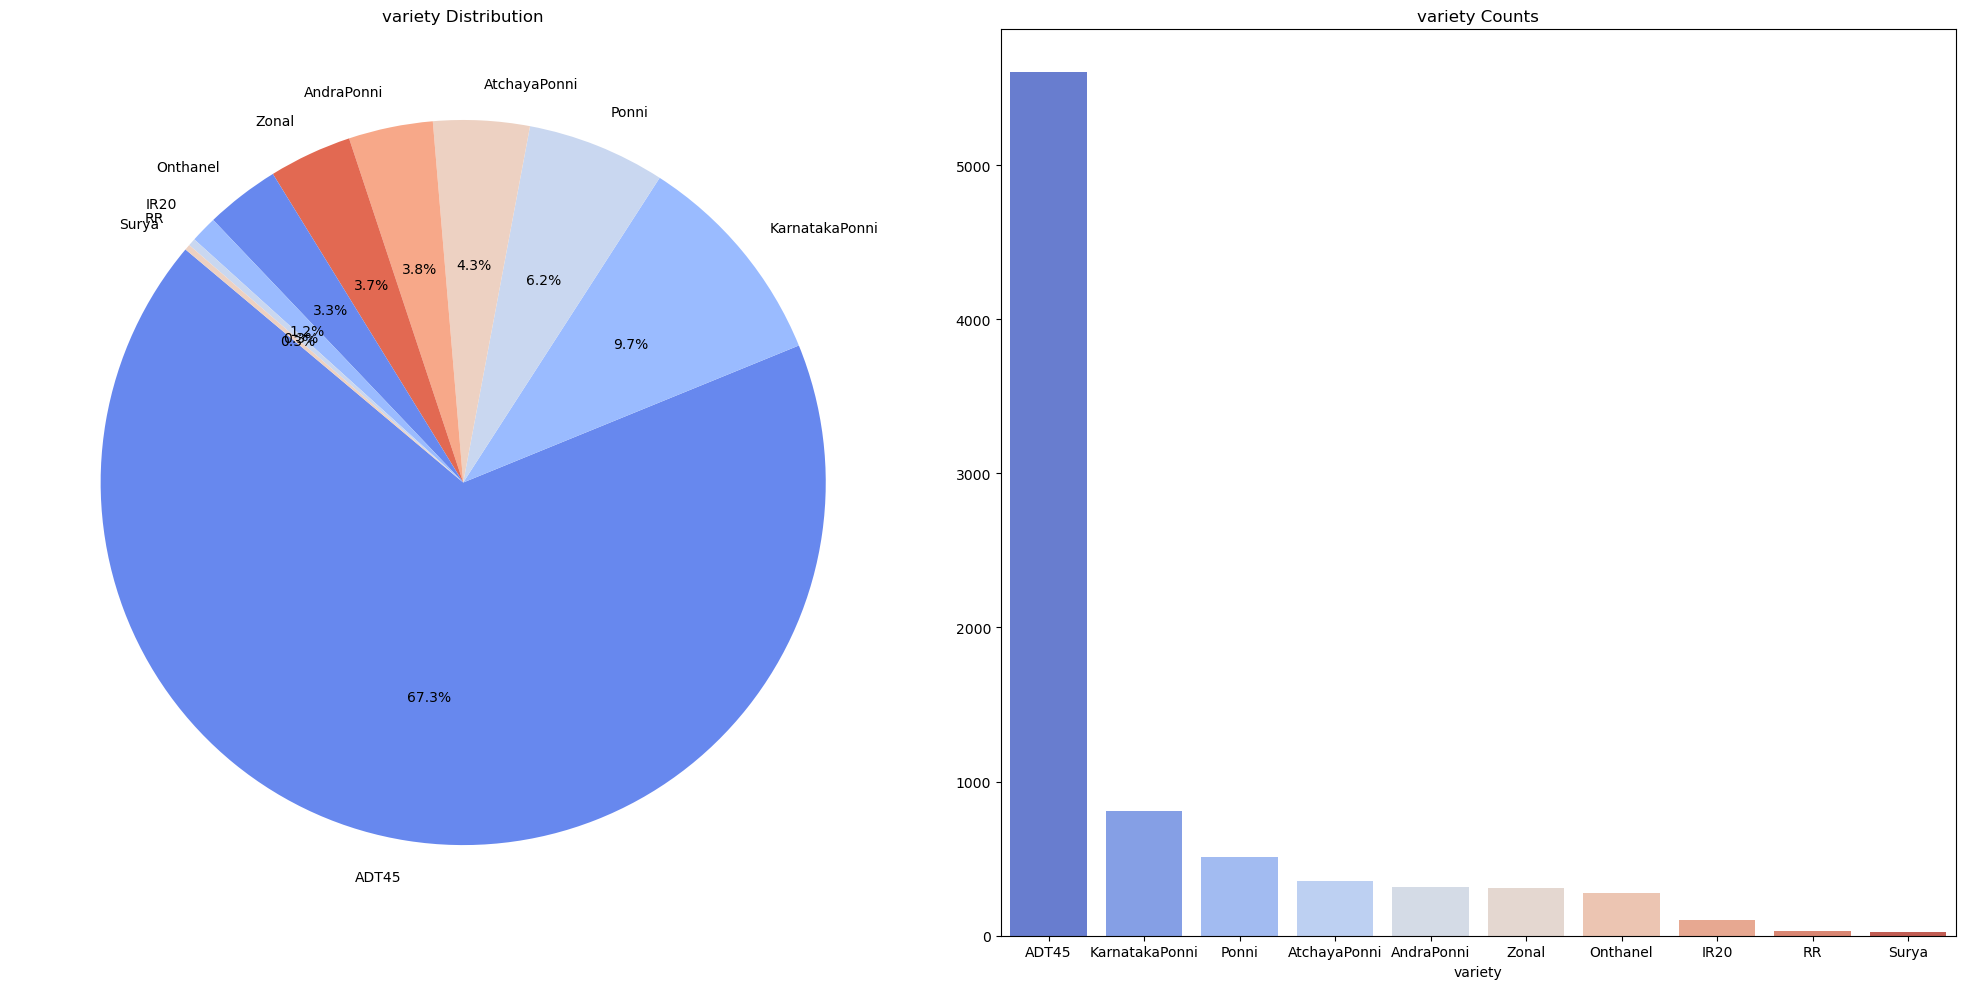

In [105]:
vi.visualize_category_distribution(train_df, "variety")

In [106]:
train_df["variety"].value_counts()

variety
ADT45             5601
KarnatakaPonni     809
Ponni              513
AtchayaPonni       357
AndraPonni         313
Zonal              308
Onthanel           276
IR20                99
RR                  28
Surya               21
Name: count, dtype: int64

#### 3.3) Handle Imbalance in `Variety` Distribution

The above pie chart provides us with the current distribution of the variety, where some varieties like ⁣`Surya`, `RR` , and `IR20` only account for under or equal to 1%, while certain varieties such as `ADT45` dominate the dataset.

To address this issue, we applied some **offline image augmentations** to increase the number of images for minority classes. The intensity of augmentation is based on the frequency tier of each variety. The logic is implemented in the `df_augmentation()` for a simple workflow.

| Tier                          | Variety Names                                     | Applied Augmentations                                                                             |
| ----------------------------- | ------------------------------------------------- | --------------------------------------------------------------------------------------------------|
| **Very Low (< 50 samples)**   | `Surya`, `RR`                                     | Rotation (±5°, ±10°, ±15°), Horizontal Flip, Vertical Flip, Brightness ±20%, Zoom-in Crop, Cutout |
| **Low (50–120 samples)**      | `IR20`                                            | Rotation (±5°, ±10°), Brightness ±20%                                                             |    
| **Mid-Low (120–400 samples)** | `Onthanel`, `AndraPonni`, `Zonal`, `AtchayaPonni` | Rotation (±5°), Random Crop                                                                       |
| **Mid (400–1000 samples)**     | `Ponni`, `KarnatakaPonni`                         | Rotation (±5°)                                                                                    |

With this approach we can diverse training sample for minority class. This preprocessing is expected to improve both accuracy and robustness in **Task 2 (Variety Classification)**


In [107]:
augmented_df, augmented_count = pr.df_augmentation(train_df)

Generating augmentations: 100%|██████████| 8325/8325 [00:44<00:00, 186.18it/s]

+------------------------------------------+
|           AUGMENTATION SUMMARY           |
+------------------------------------------+
Original dataset: 8325 images
Augmented dataset: 15913 images
Added 7588 augmented images


In [108]:
vi.print_header("Augmentation Summary for Varieties:")
for variety, count in sorted(augmented_count.items(), key=lambda x: x[1], reverse=True):
    original_count = train_df[train_df["variety"] == variety].shape[0]
    new_count = original_count + count
    print(f"- {variety}: +{count} new images (now {new_count} total)")

+---------------------------------------------------------+
|           AUGMENTATION SUMMARY FOR VARIETIES:           |
+---------------------------------------------------------+
- KarnatakaPonni: +1618 new images (now 2427 total)
- AtchayaPonni: +1071 new images (now 1428 total)
- Ponni: +1026 new images (now 1539 total)
- AndraPonni: +939 new images (now 1252 total)
- Zonal: +924 new images (now 1232 total)
- Onthanel: +828 new images (now 1104 total)
- IR20: +594 new images (now 693 total)
- RR: +336 new images (now 364 total)
- Surya: +252 new images (now 273 total)


In [109]:
train_augmented_df = pd.read_csv("inputs/meta_train_augmented.csv")

train_augmented_df

image_id                  label       variety  age  \
0                  109387.jpg                  blast  AtchayaPonni   50   
1                  109428.jpg  bacterial_leaf_blight         ADT45   72   
2                  105846.jpg             brown_spot         ADT45   55   
3                  104475.jpg                  blast         ADT45   70   
4                  102822.jpg  bacterial_leaf_streak         ADT45   68   
...                       ...                    ...           ...  ...   
15908        105389_rot_5.jpg             dead_heart      Onthanel   50   
15909  105389_crop_resize.jpg             dead_heart      Onthanel   50   
15910       108747_rot_-5.jpg                  hispa  AtchayaPonni   65   
15911        108747_rot_5.jpg                  hispa  AtchayaPonni   65   
15912  108747_crop_resize.jpg                  hispa  AtchayaPonni   65   

                                              image_path  
0                 ./inputs/train_images/blast/109387.jpg  
1      ./inputs/train_images/bacterial_leaf_blight/10...  
2            ./inputs/train_images/brown_spot/105846.jpg  
3                 ./inputs/train_images/blast/104475.jpg  
4      ./inputs/train_images/bacterial_leaf_streak/10...  
...                                                  ...  
15908  ./inputs/train_augmented_images\dead_heart\105...  
15909  ./inputs/train_augmented_images\dead_heart\105...  
15910  ./inputs/train_augmented_images\hispa\108747_r...  
15911  ./inputs/train_augmented_images\hispa\108747_r...  
15912  ./inputs/train_augmented_images\hispa\108747_c...  

[15913 rows x 5 columns]

+------------------------------------------------------------------------------------+
|           AUGMENTATION EXAMPLES FOR VERY LOW (<50) TIER - VARIETY: SURYA           |
+------------------------------------------------------------------------------------+


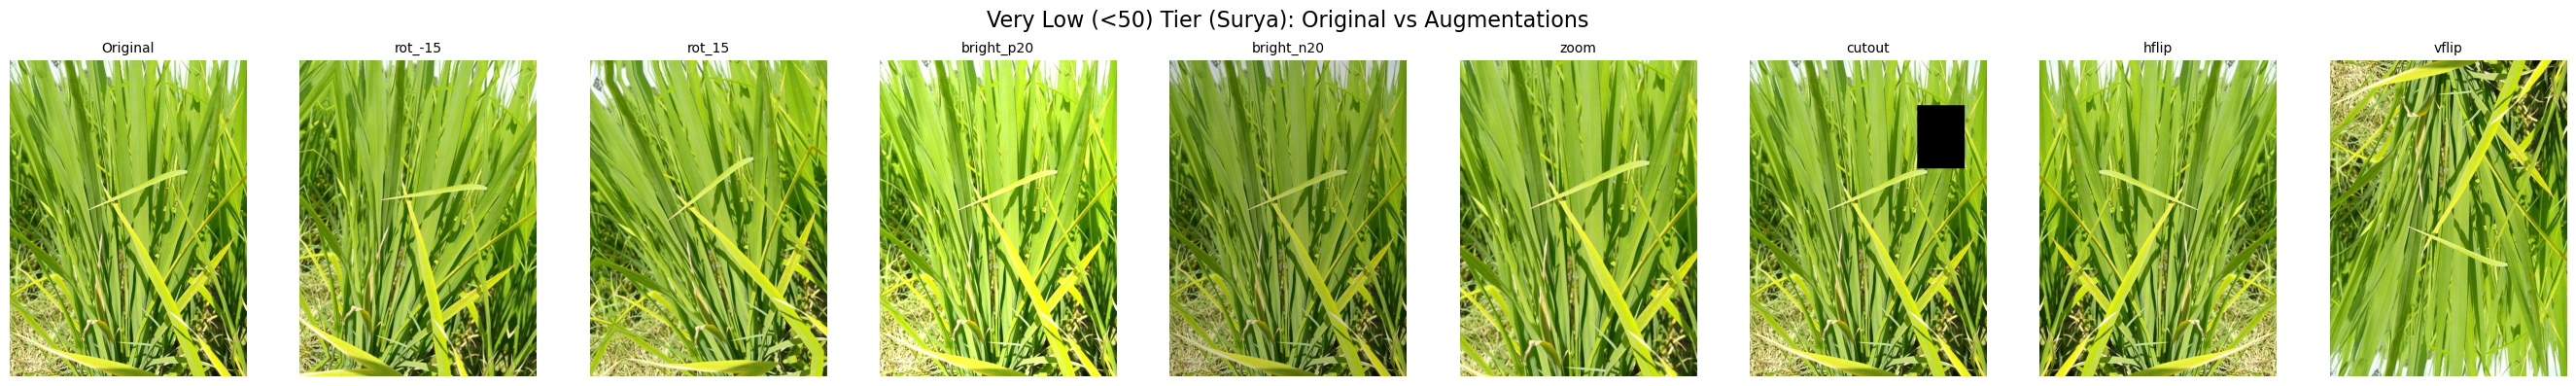

+---------------------------------------------------------------------------------+
|           AUGMENTATION EXAMPLES FOR LOW (50-120) TIER - VARIETY: IR20           |
+---------------------------------------------------------------------------------+


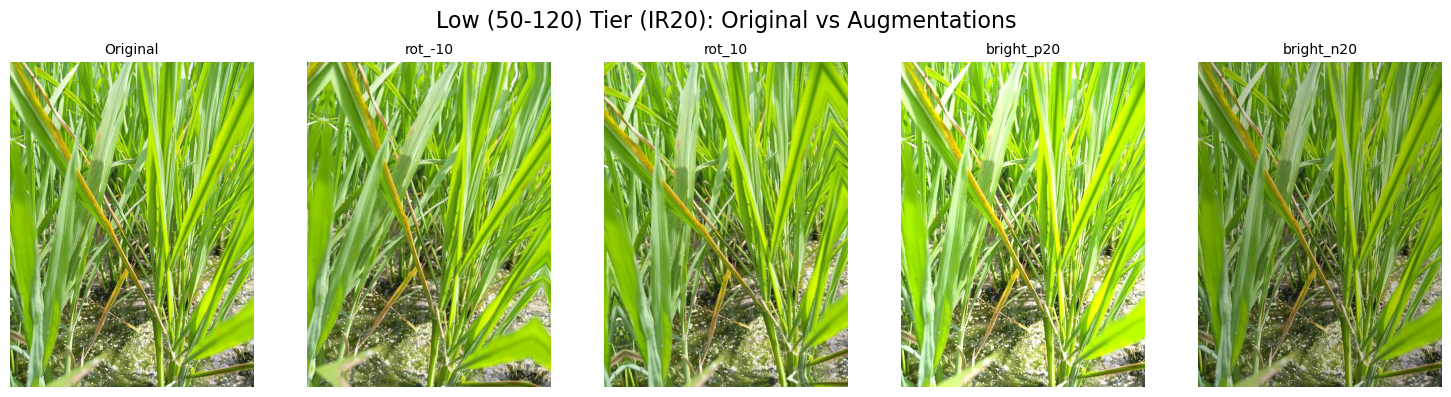

+------------------------------------------------------------------------------------------+
|           AUGMENTATION EXAMPLES FOR MID-LOW (120-400) TIER - VARIETY: ONTHANEL           |
+------------------------------------------------------------------------------------------+


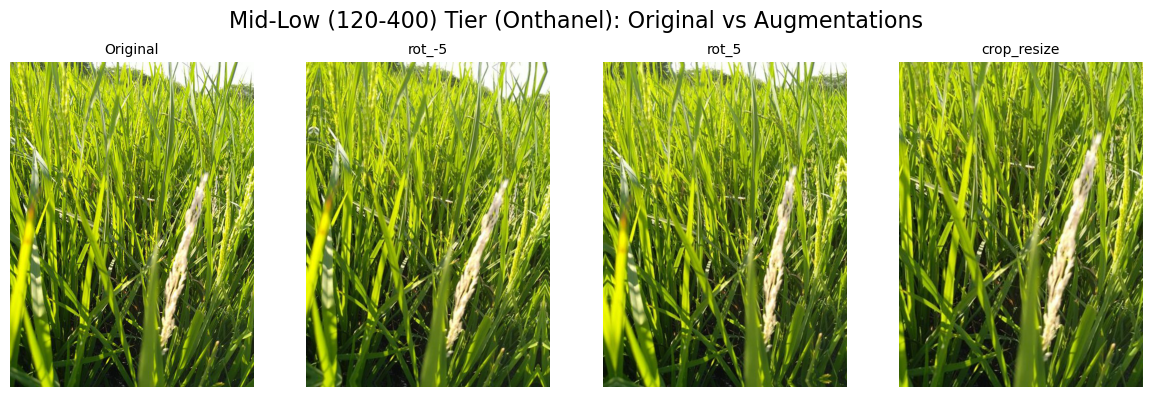

+------------------------------------------------------------------------------------+
|           AUGMENTATION EXAMPLES FOR MID (400-1000) TIER - VARIETY: PONNI           |
+------------------------------------------------------------------------------------+


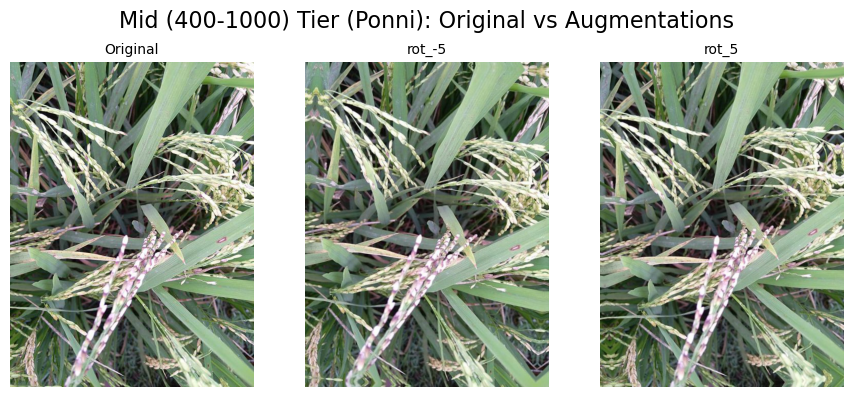

In [110]:
tiers = {
    "Very Low (<50)": ["Surya", "RR"],
    "Low (50-120)": ["IR20"],
    "Mid-Low (120-400)": ["Onthanel", "AndraPonni", "Zonal", "AtchayaPonni"],
    "Mid (400-1000)": ["Ponni", "KarnatakaPonni"],
}

augmentations = {
    "Very Low (<50)": [
        "rot_-15",
        "rot_15",
        "bright_p20",
        "bright_n20",
        "zoom",
        "cutout",
        "hflip",
        "vflip",
    ],
    "Low (50-120)": ["rot_-10", "rot_10", "bright_p20", "bright_n20"],
    "Mid-Low (120-400)": ["rot_-5", "rot_5", "crop_resize"],
    "Mid (400-1000)": ["rot_-5", "rot_5"],
}
vi.display_augmentation_examples(train_df, train_augmented_df, tiers, augmentations)

After applying offline augmentation to minority classes, the variety distribution become **more balanced**. The most dominant class `ADT45` has been reduced from **65%** to only around **35%**, while the percentages of minority classes such as `Surya`, `RR`, and `IR20` have increased their proportions. This adjustments will reduce model bias and enhance accuracy of variety classification in **Task 2**. 

However, the number of maximum variety is 5601 (`ADT45`), while the lowest variety `Surya` is only 273. It is still not enough for models to predict without bias in the domain class. To address the remaining imbalance, we apply **semi-supervised learning** to further expand the dataset.

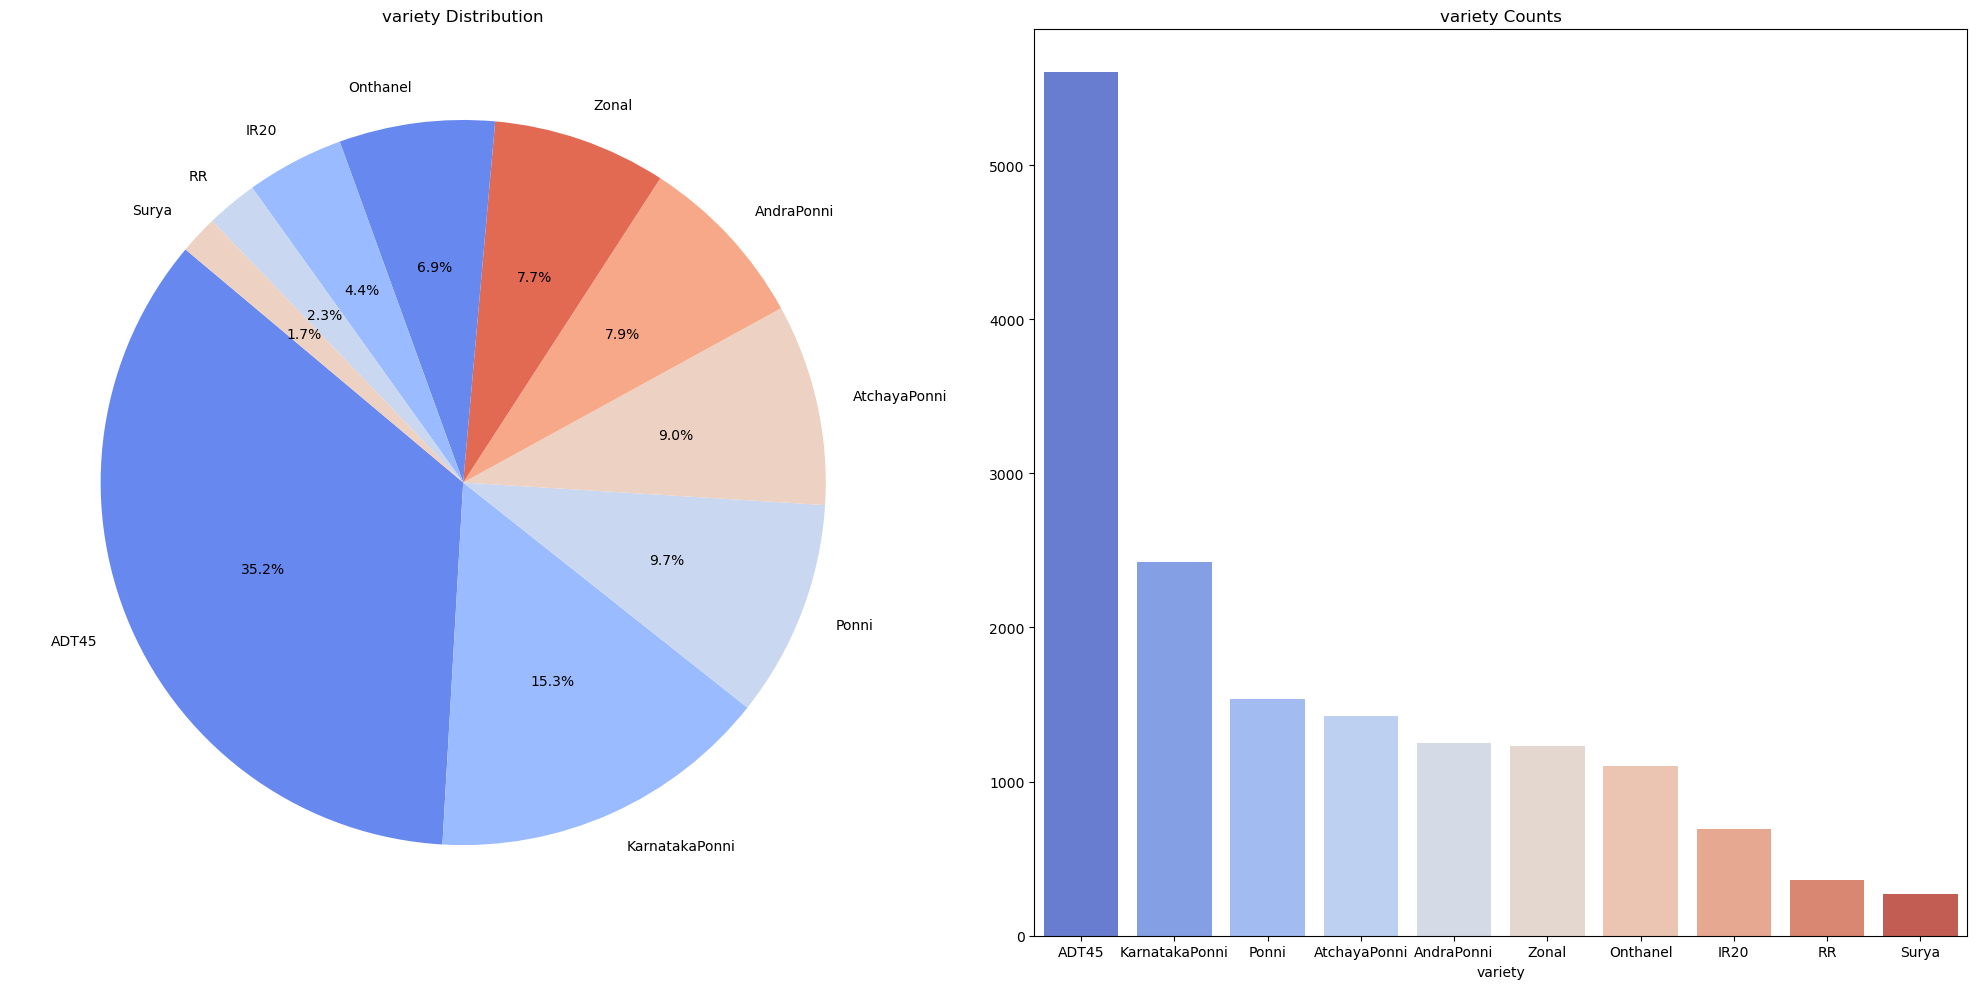

In [111]:
vi.visualize_category_distribution(train_augmented_df, "variety")

In [112]:
vi.print_header("The total number of each variety after augmenting")
train_augmented_df["variety"].value_counts()

+-----------------------------------------------------------------------+
|           THE TOTAL NUMBER OF EACH VARIETY AFTER AUGMENTING           |
+-----------------------------------------------------------------------+


variety
ADT45             5601
KarnatakaPonni    2427
Ponni             1539
AtchayaPonni      1428
AndraPonni        1252
Zonal             1232
Onthanel          1104
IR20               693
RR                 364
Surya              273
Name: count, dtype: int64

#### 3.4) Semi-supervised Learning

We set the number of classes to 10 for the 10 varieties, set batch size to 32 and the Input_DIM as 64,64,3 for faster testing, in the final code we agreed to set the code to 128,128,3 for the image clarity

In [113]:
OUTPUT_CLASSES = 10
BATCH_SIZE = 32
INPUT_DIM = (64,64,3)

## ImageDataGenerator and Data Augmentation for Training and Validation

This section outlines the process of preparing image data for training and validation using **ImageDataGenerator**.

### Training Data Preparation:
1. **Convert 'variety' column to string**:  
   The target labels in the `train_augmented_df` dataframe are cast to the `str` type using:

2. **Create a copy of the dataframe**:  
   A copy of the `train_augmented_df` dataframe is created for data preparation:

In [114]:
train_augmented_df['variety'] = train_augmented_df['variety'].astype('str')

combine_variety_df = train_augmented_df.copy()

 **Setup ImageDataGenerator for Training**:  
   An `ImageDataGenerator` instance is created for augmenting and loading images during training:

 **Load Training Data**:  
   The `flow_from_dataframe` method is used to load images and labels for training, specifying the path to the images and their corresponding labels (`'variety'`). The images are resized to **64x64** pixels and grouped into batches:

In [115]:
train_datagen = ImageDataGenerator(data_format='channels_last')
train_generator = train_datagen.flow_from_dataframe(
    dataframe=combine_variety_df,
    directory='',
    x_col='image_path',
    y_col='variety',
    target_size= (64,64),
    batch_size= BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

Found 15913 validated image filenames belonging to 10 classes.


### Validation Data Preparation:
1. **Convert 'variety' column to string for validation**:  
   The target labels in the `val_df` dataframe are also cast to the `str` type:

2. **Setup ImageDataGenerator for Validation**:  
   Another `ImageDataGenerator` instance is created for the validation data:
   ```python
   val_datagen = ImageDataGenerator(data_format='channels_last')
   ```

3. **Load Validation Data**:  
   Similarly to the training data, the validation data is loaded using `flow_from_dataframe`:

In [116]:

val_df['variety'] = val_df['variety'].astype('str')
val_datagen = ImageDataGenerator(data_format='channels_last')
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory= '',
    x_col='image_path',
    y_col='variety',
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

Found 2082 validated image filenames belonging to 10 classes.


### Simple CNN model:
add a simple CNN model for testing

In [117]:
model_variety = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model_variety.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [118]:
history = model_variety.fit(
    train_generator, validation_data=val_generator,
    epochs=25,
    verbose=1
)

Epoch 1/25
498/498 [==============================] - 228s 456ms/step - loss: 6.0553 - accuracy: 0.3222 - val_loss: 1.9578 - val_accuracy: 0.5346
Epoch 2/25
498/498 [==============================] - 102s 205ms/step - loss: 2.0075 - accuracy: 0.3569 - val_loss: 1.9297 - val_accuracy: 0.4573
Epoch 3/25
498/498 [==============================] - 92s 186ms/step - loss: 1.8119 - accuracy: 0.4060 - val_loss: 1.5484 - val_accuracy: 0.5562
Epoch 4/25
498/498 [==============================] - 93s 187ms/step - loss: 1.7106 - accuracy: 0.4387 - val_loss: 1.4877 - val_accuracy: 0.5773
Epoch 5/25
498/498 [==============================] - 92s 186ms/step - loss: 1.5524 - accuracy: 0.4902 - val_loss: 1.4275 - val_accuracy: 0.6705
Epoch 6/25
498/498 [==============================] - 104s 209ms/step - loss: 1.3834 - accuracy: 0.5332 - val_loss: 1.1848 - val_accuracy: 0.7041
Epoch 7/25
498/498 [==============================] - 95s 190ms/step - loss: 1.1903 - accuracy: 0.5891 - val_loss: 1.2136 - val


# Setup Generator for Unlabeled Data and Pseudo-Labeling

###  Setup Generator for Unlabeled Data

To work with unlabeled data, we first set up a generator using `ImageDataGenerator`. This is used to load images without labels and prepare them for pseudo-labeling

In [119]:
# Setup generator for unlabeled data
unlabeled_datagen = ImageDataGenerator(data_format='channels_last')

# Create a generator for unlabeled data
unlabeled_generator = unlabeled_datagen.flow_from_directory(
    directory='inputs/unlabel',  # Your unlabeled data directory
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=None,  # No labels
    shuffle=False
)


Found 9558 images belonging to 6 classes.


### Generate Pseudo-Labels for Unlabeled Data

After preparing the generator, we generate pseudo-labels for the unlabeled data by predicting the labels using the trained model.

1. **Make Predictions on Unlabeled Data**: Use the trained model to predict the classes of the unlabeled data.

2. **Filter High-Confidence Predictions**: Only predictions with a confidence score above a certain threshold (e.g., 0.9) are considered.


3. **Map Class Indices to Class Names**: Convert the predicted class indices to their corresponding class names using the class indices from the training generator.

In [120]:
print("\nGenerating pseudo-labels for unlabeled data...")
# 1. Predict on unlabeled data (already in your code)
predictions = model_variety.predict(unlabeled_generator)
predicted_classes = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)

# 2. Filter high-confidence predictions
confidence_threshold = 0.9
high_confidence_mask = confidence_scores > confidence_threshold

# 3. Map class indices to variety class names
class_indices = train_generator.class_indices  # Make sure this is defined from your labeled data generator
inv_class_indices = {v: k for k, v in class_indices.items()}
predicted_varieties = [inv_class_indices[idx] for idx in predicted_classes]

# 4. Prepare DataFrame for high-confidence predictions
image_paths = np.array(unlabeled_generator.filenames)
image_ids = [os.path.basename(path) for path in image_paths]

high_confidence_df = pd.DataFrame({
    'image_id': np.array(image_ids)[high_confidence_mask],
    'label': '',  # Unknown for unlabeled data
    'variety': np.array(predicted_varieties)[high_confidence_mask],
    'age': '',    # Unknown for unlabeled data
    'image_path': image_paths[high_confidence_mask]
})


Generating pseudo-labels for unlabeled data...
299/299 [==============================] - 135s 453ms/step


# Iterative Pseudo-Labeling and Model Training

This section outlines the process of iteratively adding pseudo-labeled data and retraining the model. The approach is repeated for a set number of iterations, progressively improving the model by including high-confidence predictions from unlabeled data.

### 1. Initialize DataFrames for Iteration
```python
original_combine_df = train_augmented_df.copy()
added_pseudo_df = pd.DataFrame(columns=original_combine_df.columns)
```
- **`original_combine_df`**: The original labeled training dataset.
- **`added_pseudo_df`**: A DataFrame to store the pseudo-labeled data.

### 2. Define Selected Varieties and Confidence Threshold
```python
selected_varieties = ['RR', 'Surya', 'IR20']
confidence_threshold = 0.9
```
- **`selected_varieties`**: The varieties to be selected for pseudo-labeling.
- **`confidence_threshold`**: Only predictions with confidence higher than **0.9** will be considered.

In [121]:
original_combine_df = train_augmented_df.copy()
added_pseudo_df = pd.DataFrame(columns=original_combine_df.columns)

selected_varieties = ['RR', 'Surya', 'IR20']
confidence_threshold = 0.9

### 3. Iterative Process (Repeated for 10 Iterations)

#### **Iteration Steps:**
- **Reset Data**: Combine original labeled data with pseudo-labeled data added so far.

- **Update Generator**: Update the training generator with the new combined data.

- **Train Model**: Train the model for 1 epoch on the updated dataset.


- **Make Predictions on Unlabeled Data**: Predict labels for the unlabeled data.


- **Map Class Indices to Class Names**: Convert predicted class indices back to their respective variety names.

- **Prepare DataFrame for High-Confidence Predictions**: Filter out predictions with low confidence and prepare the DataFrame.


- **Filter for Selected Varieties**: Only include predictions for the selected varieties.

- **Remove Already-Added Data**: Ensure that previously added pseudo-labeled data is not added again.


- **Add to Pseudo-Label Data**: Append the new high-confidence samples to `added_pseudo_df`.

In [122]:
for iteration in range(6):
    print(f"\n=== Iteration {iteration+1} ===")
    
    # 1. Reset combine_df to original + all added so far
    combine_df = pd.concat([original_combine_df, added_pseudo_df], ignore_index=True)
    
    # 2. Update train_generator to use the new combine_df
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=combine_df,
        directory='',
        x_col='image_path',
        y_col='variety',
        target_size=(64, 64),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        seed=42
    )
    
    # 3. Train the model
    model_variety.fit(
        train_generator,
        validation_data=val_generator,
        epochs=1,  
        verbose=1
    )
    
    # 4. Predict on unlabeled data
    predictions = model_variety.predict(unlabeled_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1)
    
    # 5. Map class indices to variety names
    class_indices = train_generator.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    predicted_varieties = [inv_class_indices[idx] for idx in predicted_classes]
    
    # 6. Prepare DataFrame for high-confidence predictions
    image_paths = np.array(unlabeled_generator.filepaths)
    image_ids = [os.path.basename(path) for path in image_paths]
    
    high_confidence_mask = confidence_scores > confidence_threshold
    high_confidence_df = pd.DataFrame({
        'image_id': np.array(image_ids)[high_confidence_mask],
        'label': '',  # Unknown for unlabeled data
        'variety': np.array(predicted_varieties)[high_confidence_mask],
        'age': '',    # Unknown for unlabeled data
        'image_path': image_paths[high_confidence_mask]
    })
    
    # 7. Filter for selected varieties
    filtered_df = high_confidence_df[high_confidence_df['variety'].isin(selected_varieties)]
    
    # 8. Remove already-included images
    already_added_ids = set(added_pseudo_df['image_id'])
    filtered_df = filtered_df[~filtered_df['image_id'].isin(already_added_ids)]
    
    # 9. Add to added_pseudo_df
    added_pseudo_df = pd.concat([added_pseudo_df, filtered_df], ignore_index=True)
    
    # 10. Print the newly added rows for this iteration
    print(f"Added {len(filtered_df)} new high-confidence samples:")
    print(filtered_df)


=== Iteration 1 ===
Found 15913 validated image filenames belonging to 10 classes.
299/299 [==============================] - 62s 208ms/step
Added 190 new high-confidence samples:
                      image_id label variety age  \
2     BACTERAILBLIGHT3_006.jpg         Surya       
10    BACTERAILBLIGHT3_020.jpg         Surya       
53    BACTERAILBLIGHT3_096.jpg         Surya       
74    BACTERAILBLIGHT3_134.JPG          IR20       
121   BACTERAILBLIGHT3_219.jpg         Surya       
...                        ...   ...     ...  ..   
5346           TUNGRO1_252.JPG          IR20       
5347           TUNGRO1_254.JPG          IR20       
5710           TUNGRO4_016.jpg         Surya       
5843           TUNGRO5_105.jpg         Surya       
5906             TUNGRO5_4.jpg          IR20       

                                             image_path  
2     inputs/unlabel\bacterial_leaf_blight\BACTERAIL...  
10    inputs/unlabel\bacterial_leaf_blight\BACTERAIL...  
53    inputs/unlabel

### 4. Save the combined Dataframe and print out the results

In [123]:
# After all iterations, save the final combined DataFrame
final_df = pd.concat([original_combine_df, added_pseudo_df], ignore_index=True)
os.makedirs('inputs', exist_ok=True)
final_df.to_csv('inputs/meta_train_semi_supervise.csv', index=False)
print("\nFinal combined DataFrame saved to inputs/meta_train_semi_supervise.csv")


Final combined DataFrame saved to inputs/meta_train_semi_supervise.csv


### Finalized and Generate the complete results for the Variety Classification

In [124]:
final_df['variety'] = final_df['variety'].astype('str')

task2_train = ImageDataGenerator(data_format='channels_last')
task2_generator = task2_train.flow_from_dataframe(
    dataframe=final_df,
    directory='',
    x_col='image_path',
    y_col='variety',
    target_size= (64,64),
    batch_size= 32,
    class_mode='categorical',
    seed=42
)

Found 18672 validated image filenames belonging to 10 classes.


In [125]:
print(final_df['variety'].value_counts())

variety
ADT45             5601
Surya             2757
KarnatakaPonni    2427
Ponni             1539
AtchayaPonni      1428
AndraPonni        1252
Zonal             1232
Onthanel          1104
IR20               904
RR                 428
Name: count, dtype: int64


In [126]:
def visualize_category_distribution(df, column_name):
    """
    Visualizes the distribution of categories from a specified column in the provided DataFrame.

    Parameters:
    - df: pandas DataFrame containing the column to visualize.
    - column_name: The column name whose distribution will be visualized.
    """
    # Calculate the frequency of each category in the specified column
    category_counts = df[column_name].value_counts()

    # Create a figure with two side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), facecolor="white")

    # Plot a pie chart in the first subplot
    color_palette = sns.color_palette("coolwarm")
    sns.set_palette(color_palette)
    axes[0].pie(
        category_counts, labels=category_counts.index, autopct="%1.1f%%", startangle=140
    )
    axes[0].set_title(f"{column_name} Distribution")

    # Plot a bar chart in the second subplot with the hue parameter
    sns.barplot(
        x=category_counts.index,
        y=category_counts.values,
        ax=axes[1],
        hue=category_counts.index,
        palette="coolwarm",
        legend=False,
    )
    axes[1].set_title(f"{column_name} Counts")

    # Adjust layout to ensure no overlapping of elements
    plt.tight_layout()

    # Display the plots
    plt.show()



   

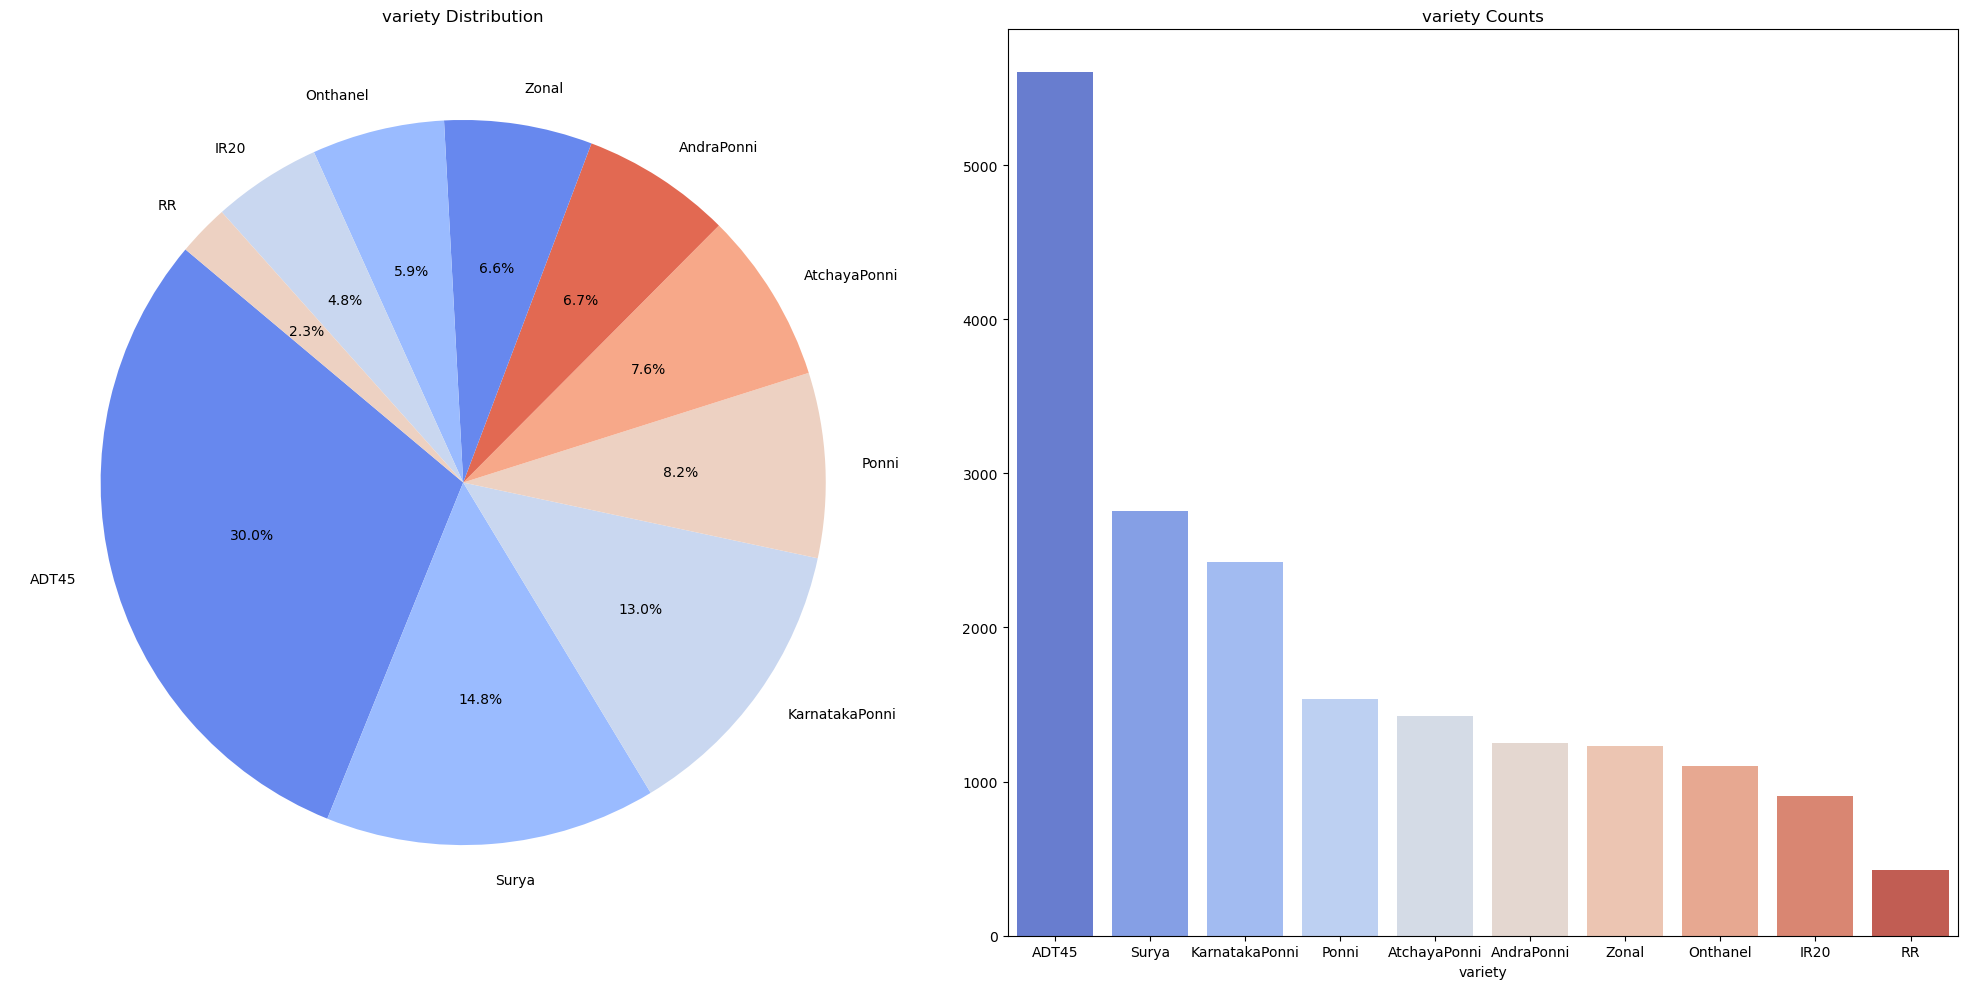

In [127]:
 visualize_category_distribution(final_df,"variety")


## Paddy Field Variety Classification Model SelectionSelection

### Challenge: Class Imbalance
In this paddy field variety classification task, **ADT45** is overwhelmingly dominant in the dataset. Despite using semi-supervised learning and data augmentation, the dataset is still imbalanced leading to model bias towards predicting ADT45.

with the predetermined criterias for model selections and the challenges of class imbalance, EfficientNet and ResNet are selected for model training
#### **EfficientNet**

1. **Efficient Architecture for Fine-grained Classification**:
   EfficientNet uses a compound scaling method that balances **accuracy** and **computational efficiency**. Its scalability helps in fine-grained tasks like distinguishing paddy varieties, even with an imbalanced dataset.

2. **Robust Feature Extraction**:
   Pre-trained on ImageNet, EfficientNet extracts rich features, helping it recognize even subtle differences between varieties.

3. **Transfer Learning**:
   EfficientNet benefits from transfer learning, speeding up training and reducing the impact of class imbalance by leveraging pre-trained knowledge.

4. **Improved Generalization**:
   Its design promotes **better generalization** to unseen data, reducing overfitting, a common issue with imbalanced datasets.

#### **ResNet50**

1. **Residual Connections**:
   ResNet50 uses **residual connections** to make training deeper networks easier, enabling it to learn hierarchical patterns essential for distinguishing between paddy varieties.

2. **Learning Robust Representations**:
   The deep architecture allows ResNet50 to learn **robust representations**, capturing complex features that differentiate subtle classes.

3. **Mitigating Overfitting**:
   Pre-training on large datasets like ImageNet and fine-tuning helps prevent overfitting, ensuring that even minority classes are adequately learned.

4. **Works Well with Data Augmentation**:
   ResNet50 handles augmented data well, improving model generalization even when some classes are underrepresented.

### Addressing Class Imbalance

- **Feature Extraction**: Both models excel at extracting distinguishing features from imbalanced data.
- **Transfer Learning**: Using pre-trained models ensures that the models rely on general features to make better predictions.
- **Fine-tuning**: Techniques like class weighting and adaptive learning rates help mitigate class imbalance.


### **EfficientNetB0 vs ResNet50 for Paddy Field Classification**

### 1. Performance Metrics

#### Accuracy, Precision, Recall, F1-score
- **EfficientNetB0**: Achieves high accuracy, precision, recall, and F1-score due to compound scaling and efficiency.
- **ResNet50**: Good performance in accuracy, precision, recall, and F1-score, but may require more fine-tuning compared to EfficientNetB0.

#### AUC-ROC
- **EfficientNetB0**: AUC-ROC tends to be high due to better generalization and balanced performance across classes.
- **ResNet50**: AUC-ROC tends to be solid, but might not be as high as EfficientNetB0 for complex multi-class tasks.

### Generalization
- **EfficientNetB0**: Generates high generalization ability, particularly due to its compound scaling mechanism.
- **ResNet50**: Generalization may be affected by the number of layers and the risk of overfitting without proper tuning.

### 2. Cost Metrics

#### Training Time
- **EfficientNetB0**: Relatively fast training time due to fewer parameters and efficient architecture.
- **ResNet50**: Relatively slower training time due to a higher number of parameters.

#### Inference Time
- **EfficientNetB0**: Fast inference time, particularly in resource-constrained environments.
- **ResNet50**: Inference time may be slightly longer than EfficientNetB0 due to more parameters and deeper architecture.

#### Resource Usage
- **EfficientNetB0**: Efficient in terms of memory and computational resources due to fewer parameters.
- **ResNet50**: More resource-intensive, requiring more memory and computational power due to deeper architecture.

### 3. Risk Metrics

#### Robustness
- **EfficientNetB0**: Robust against noise and missing data thanks to its well-designed architecture.
- **ResNet50**: Relatively robust, but may need additional regularization to perform well on noisy or missing data.

#### Overfitting Risk
- **EfficientNetB0**: Less risk of overfitting due to its smaller parameter count and efficient regularization.
- **ResNet50**: Higher risk of overfitting unless regularization strategies are used due to the larger model size.

#### Bias and Fairness
- **EfficientNetB0**: Reduced risk of bias, since the model uses a more balanced approach to scaling.
- **ResNet50**: Potential for bias if not carefully tuned for diverse data, especially for smaller datasets.

### 4. Compatibility

#### Integration
- **EfficientNetB0**: Easily integrable into cloud or edge devices due to its lightweight design.
- **ResNet50**: Integrates well into various cloud environments but may need more adaptation for edge devices due to its size.

#### Data Formats
- **EfficientNetB0**: Can accept various sensor or imaging device data formats due to flexible input preprocessing.
- **ResNet50**: Supports common data formats, but preprocessing might be more specific compared to EfficientNetB0.

### 5. Maintainability and Transferability

#### Ease of Update
- **EfficientNetB0**: Can be retrained or fine-tuned efficiently with minimal computational overhead.
- **ResNet50**: Can be updated or fine-tuned, but requires more resources and time compared to EfficientNetB0.

#### Documentation
- **EfficientNetB0**: Well-documented architecture and training process, supported by the broader EfficientNet framework.
- **ResNet50**: Comprehensive documentation available due to ResNet's popularity, but might require more technical understanding.

#### Transferability
- **EfficientNetB0**: Can be easily adapted to new regions or varieties with fine-tuning and minimal adjustments.
- **ResNet50**: Adaptable to new regions or varieties, but fine-tuning may require more effort due to the complexity of the model.


In [128]:
# Create base models
efficientnet = EfficientNetB0(input_shape=(64, 64, 3), include_top=False, weights=None)

resnet = ResNet50(input_shape=(64, 64, 3), include_top=False, weights=None)

# Analyze both models
tr.analyze_model_layers(efficientnet, "EfficientNetB0")
tr.analyze_model_layers(resnet, "ResNet50")


# Create and analyze the full models with their heads
def create_full_model(base_model, model_name):
    model = models.Sequential(
        [
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(10, activation="softmax"),
        ]
    )
    return model


efficientnet_full = create_full_model(efficientnet, "EfficientNetB0")
resnet_full = create_full_model(resnet, "ResNet50")

print("\n=== Full Model Analysis (with heads) ===")
tr.analyze_model_layers(efficientnet_full, "EfficientNetB0 Full")
tr.analyze_model_layers(resnet_full, "ResNet50 Full")


=== EfficientNetB0 Layer Analysis ===
Total number of layers: 237

Layer type distribution:
InputLayer: 1
Rescaling: 1
Normalization: 1
ZeroPadding2D: 5
Conv2D: 65
BatchNormalization: 49
Activation: 33
DepthwiseConv2D: 16
GlobalAveragePooling2D: 16
Reshape: 16
Multiply: 16
Dropout: 9
Add: 9

Total trainable parameters: 4,049,571

=== ResNet50 Layer Analysis ===
Total number of layers: 175

Layer type distribution:
InputLayer: 1
ZeroPadding2D: 2
Conv2D: 53
BatchNormalization: 53
Activation: 49
MaxPooling2D: 1
Add: 16

Total trainable parameters: 23,587,712

=== Full Model Analysis (with heads) ===

=== EfficientNetB0 Full Layer Analysis ===
Total number of layers: 4

Layer type distribution:
Functional: 1
GlobalAveragePooling2D: 1
Dense: 2

Total trainable parameters: 4,214,829

=== ResNet50 Full Layer Analysis ===
Total number of layers: 4

Layer type distribution:
Functional: 1
GlobalAveragePooling2D: 1
Dense: 2

Total trainable parameters: 23,851,274


### EfficientnetB0 training

In [129]:
def create_efficientnetb0_model():
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=(64, 64, 3),
        include_top=False,
        weights=None,  
        pooling="avg",
    )
    model = models.Sequential([base_model, layers.Dense(10, activation="softmax")])
    return model


# Create and compile model
model = create_efficientnetb0_model()
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy", 
    metrics=["accuracy"],
)

# Train model
history = model.fit(
    task2_generator,  
    validation_data=val_generator,  
    epochs=5,
    verbose=2,
)

Epoch 1/5
584/584 - 481s - loss: 1.5627 - accuracy: 0.4844 - val_loss: 1.1493 - val_accuracy: 0.5845 - 481s/epoch - 824ms/step
Epoch 2/5
584/584 - 433s - loss: 0.8516 - accuracy: 0.7092 - val_loss: 0.5133 - val_accuracy: 0.8184 - 433s/epoch - 742ms/step
Epoch 3/5
584/584 - 449s - loss: 0.4877 - accuracy: 0.8387 - val_loss: 0.5707 - val_accuracy: 0.8103 - 449s/epoch - 770ms/step
Epoch 4/5
584/584 - 441s - loss: 0.3248 - accuracy: 0.8936 - val_loss: 0.7357 - val_accuracy: 0.7474 - 441s/epoch - 755ms/step
Epoch 5/5
584/584 - 441s - loss: 0.2200 - accuracy: 0.9279 - val_loss: 0.3330 - val_accuracy: 0.9006 - 441s/epoch - 756ms/step


In [130]:
import pickle

with open('efficientnet_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)


print(loaded_history.keys())  # List of available metrics like loss, accuracy, etc.

import pickle
with open('efficientnet_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

FileNotFoundError: [Errno 2] No such file or directory: 'efficientnet_history.pkl'

In [ ]:
# Save model
model.save("efficientnetb0_paddy_classifier.h5")

Resnet50 Training

In [ ]:
# from tensorflow.keras.applications import ResNet50
resnet50_model = models.Sequential(
    [
        ResNet50(
            input_shape=(64, 64, 3),
            include_top=False,
            weights=None,  
            pooling="avg",
        ),
        layers.Dense(10, activation="softmax"),
    ]
)

resnet50_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",  
    metrics=["accuracy"],
)

resnet50_history = resnet50_model.fit(
    task2_generator, validation_data=val_generator, epochs=5, verbose=1
)

resnet50_model.save("resnet50_paddy_classifier.h5")

Epoch 1/5


KeyboardInterrupt: 

### RESULTS COMPARISON

### 1. history

In [ ]:
# Usage:
tr.plot_history([history, resnet50_history], ["EfficientNetB0", "ResNet50"])

### 2. ROC curve

In [ ]:
tr.plot_roc_curves(
    [model, resnet50_model],
    ['EfficientNetB0', 'ResNet50'],
    val_generator,
    num_classes= 10
)

In [2]:
tr.evaluate_model(model, val_generator, "effientNet")

NameError: name 'tr' is not defined

As mentioned in the data augmented section, we shall use class weight for handling the imbalanced data.

we get the class labels to compute the class weights

In [ ]:
# --- Compute balanced class weights ---
class_labels = task2_generator.classes

Class weight is set to balanced compute weights that are inversely proportional to class frequencies. This means that underrepresented classes will get higher weights, and overrepresented classes will get lower weights to balanced out the heavily biased variety classes

In [ ]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(class_labels), y=class_labels
)

finally, this converts the class_weights array into a dictionary. The dictionary will have the class indices as keys and the computed class weights as the corresponding values. 

In [ ]:
# Convert to a dictionary for Keras
class_weight_dict = dict(enumerate(class_weights))


## EfficientNetB0 Advanced Model Overview

This model uses the **EfficientNetB0** architecture as the base with added layers and techniques for improved performance.

### Model Layers:

1. **EfficientNetB0 (Base Model)**  
   - Excludes top layers (`include_top=False`) for transfer learning.
   - Uses global average pooling (`pooling='avg'`) to reduce feature maps.

2. **Dropout**  
   - **30%** dropout in the first layer and **20%** in the second to prevent overfitting. Higher dropout in earlier layers helps regularize deep networks.

3. **Dense Layer (Hidden)**  
   - **128 units with ReLU activation**: Provides sufficient complexity for learning.
   - **L2 regularization (`regularizers.l2(0.0001)`)**: Prevents large weights, improving generalization and reducing overfitting.

4. **Dense Layer (Output)**  
   - **Softmax activation** with `NUM_CLASSES` neurons for multi-class classification.
   - **L2 regularization (`regularizers.l2(0.001)`)**: Stronger regularization on the output layer to reduce overfitting and control complexity.


In [ ]:
efficientnet_adv = models.Sequential([
    EfficientNetB0(
        input_shape=(128, 128, 3),
        include_top=False,
        weights=None,
        pooling='avg'
    ),
    layers.Dropout(0.3),         
    layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.0001)
    ),
    layers.Dropout(0.2),
    layers.Dense(
        OUTPUT_CLASSES,
        activation='softmax',
        kernel_regularizer=regularizers.l2(0.001)
    )
])

compile the model with a lower learning rate of 0.0005 and use reducLROnPlateau for the adaptive learning rate

In [ ]:
efficientnet_adv.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6
)

Set early stopping and Checkpoint to save the best model and to prevent unnecessary epochs

In [ ]:
from keras import callbacks

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)
model_ckpt = callbacks.ModelCheckpoint(
    'efficientnetb0_advanced_best.h5', save_best_only=True, monitor='val_loss'
)

In [ ]:
# Training with balanced class weights
history = efficientnet_adv.fit(
    task2_generator,
    validation_data=val_generator,
    epochs=25,  # For quick testing
    callbacks=[early_stop, model_ckpt, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/5


KeyboardInterrupt: 